# Notebook to view the parameters of the generated populations

Load the parameters for the three populations with different spin magnitude and tilt distributions but the same $\chi_\mathrm{eff}$ distribution. Compare them to the underlying distributions to see which systems passed the SNR threshold.

In [2]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import h5py 

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)
import matplotlib.lines as mlines

import seaborn as sns
import pandas as pd

import sys

## Load in data

In [3]:
pop1_underlying = pd.read_json('underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2_underlying = pd.read_json('underlying_population2_mediumSpin_fullmassrange.json')
pop3_underlying = pd.read_json('underlying_population3_lowSpinAligned_fullmassrange.json')

pop1_detected = pd.read_json('population1_highSpinPrecessing_fullmassrange.json')
pop2_detected = pd.read_json('population2_mediumSpin_fullmassrange.json')
pop3_detected = pd.read_json('population3_lowSpinAligned_fullmassrange.json')

In [4]:
# For plotting 
inj_kwargs = dict(ls=':', histtype='step', density=True, lw=1.5, label='underlying')
det_kwargs = dict(histtype='step', density=True, lw=1.5, label='passes snr cutoff')

## Look at spin distributions 

The effective spin $\chi_\mathrm{eff}$ distribution should be the same for each population, while the component spin magnitudes $\chi$ and tilt angles $\cos\theta$ distributions - and thus that for $\chi_\mathrm{p}$ - should be different. The distribution of in-plane angles $\phi_{12}$ should also be the same (uniform) for all three populations.

In [5]:
# Calculate chi_p
def calculate_ChiP(chi1, chi2, sint1, sint2, q): 
    term1 = chi1*sint1
    term2 = (2 + 4*q)/(4 + 3*q)*q*chi2*sint2
    chip = np.maximum(term1,term2)
    return chip 

In [6]:
# Calculate phi_12 
def calculate_phi12(s1x,s1y,s2x,s2y): 
    phi1 = np.arctan(s1y/s1x)
    phi2 = np.arctan(s2y/s2x)
    phi12 = phi2-phi1
    return phi12

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


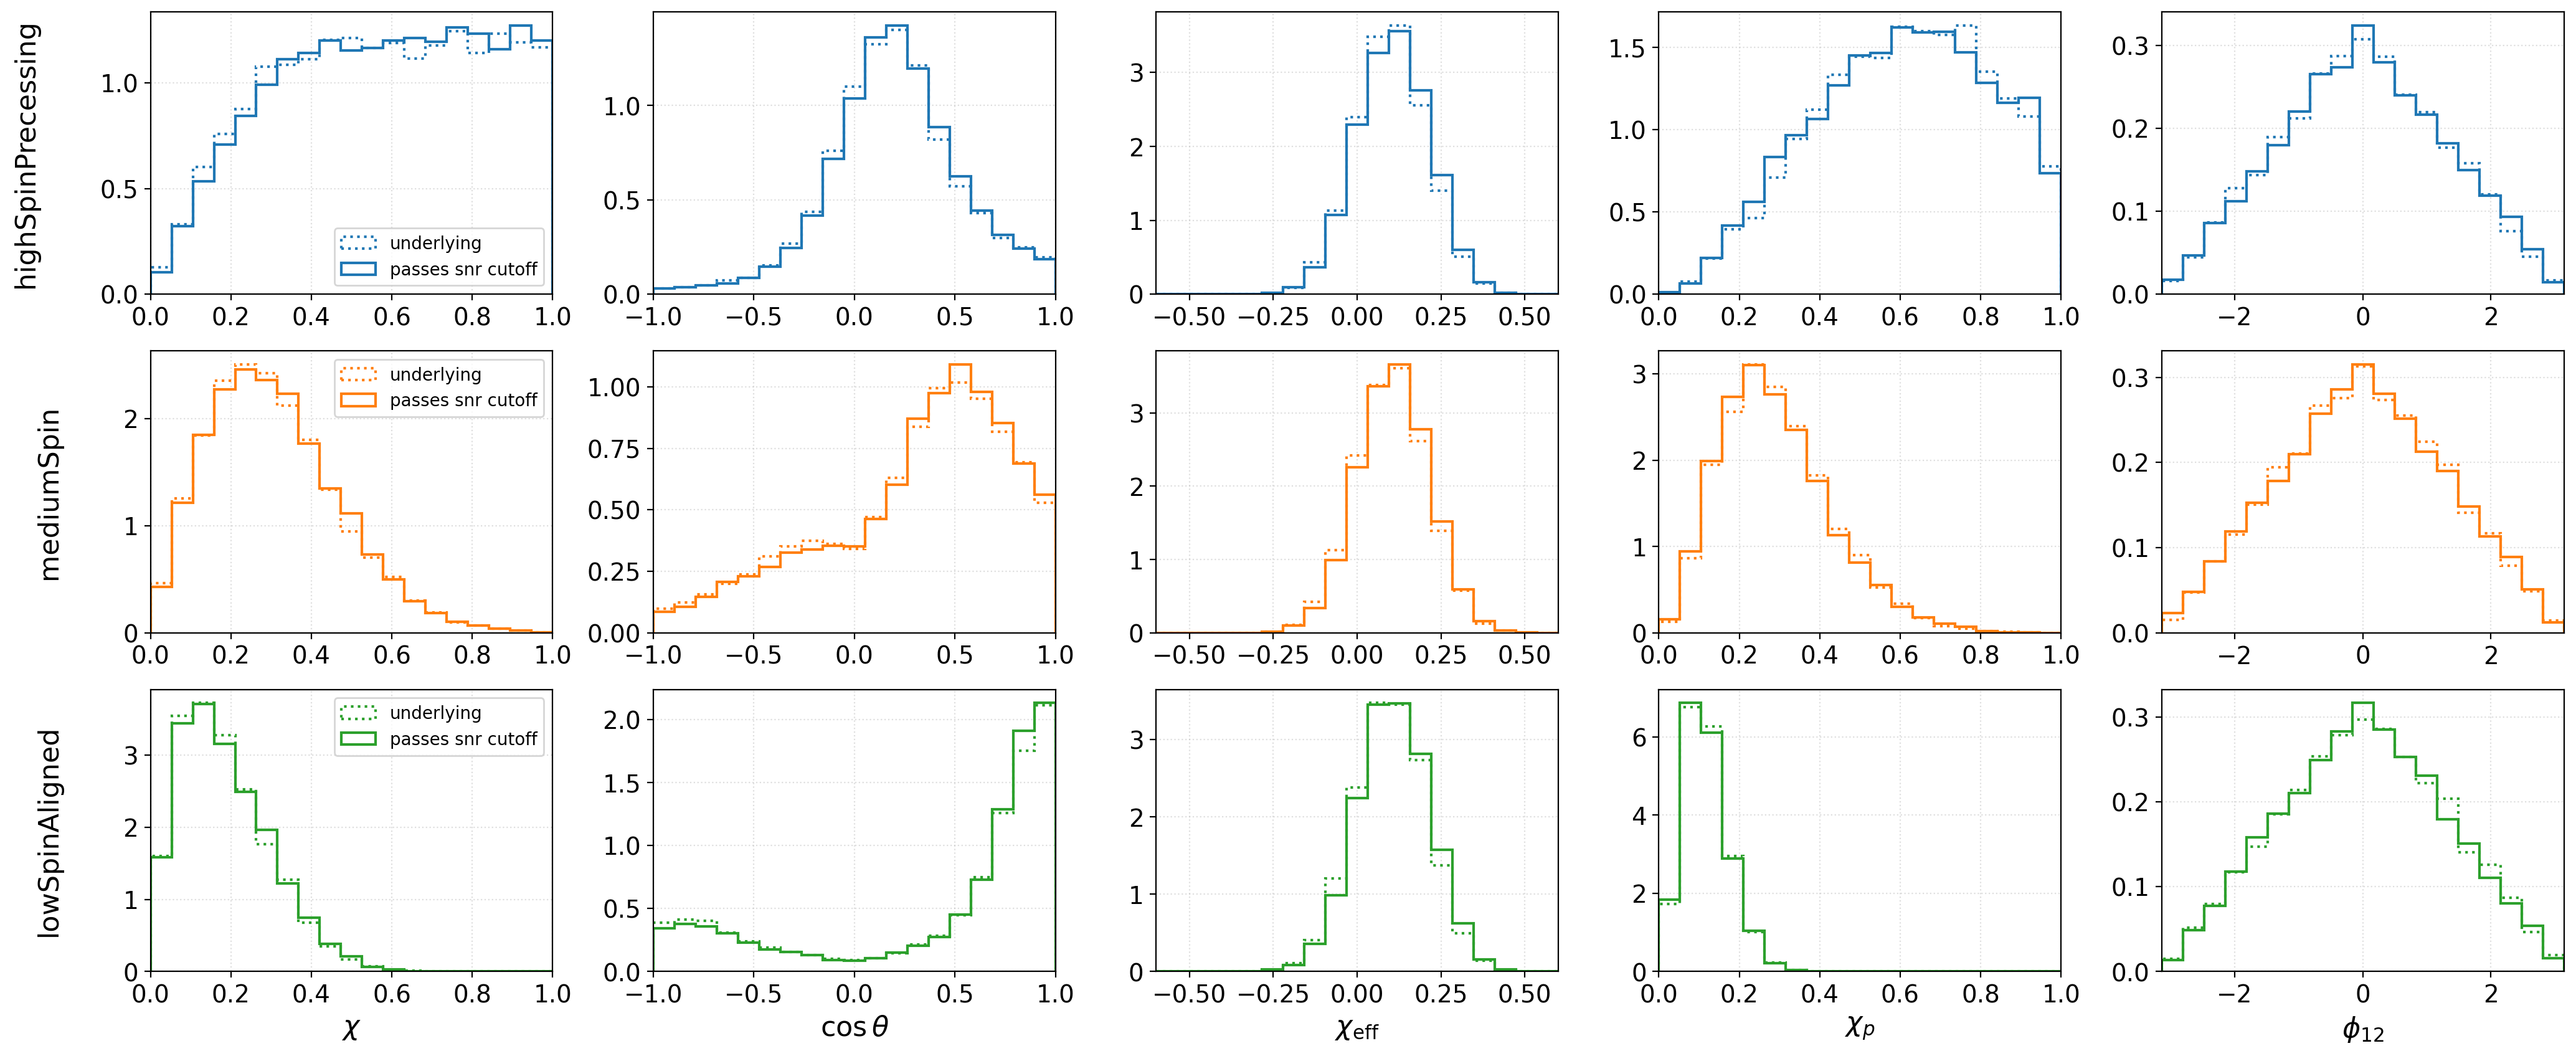

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25,10))

for i,pop_underlying in enumerate([pop1_underlying, pop2_underlying, pop3_underlying]):
    
    # spin magnitude
    chi1 = np.sqrt(pop_underlying.s1x**2 + pop_underlying.s1y**2 + pop_underlying.s1z**2)
    chi2 = np.sqrt(pop_underlying.s2x**2 + pop_underlying.s2y**2 + pop_underlying.s2z**2)
    chi = np.concatenate((chi1,chi2))
    axes[i][0].hist(chi, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, 1, 20))
    axes[i][0].set_xlim(0,1)
    
    # tilt angle
    cost1 = pop_underlying.s1z/chi1
    cost2 = pop_underlying.s2z/chi2
    cost = np.concatenate((cost1,cost2))
    axes[i][1].hist(cost, **inj_kwargs, color=f'C{i}',bins=np.linspace(-1, 1, 20))
    axes[i][1].set_xlim(-1,1)
    
    # chi effective
    chieff = (pop_underlying.m1*pop_underlying.s1z + pop_underlying.m2*pop_underlying.s2z)/(pop_underlying.m1 + pop_underlying.m2)
    axes[i][2].hist(chieff, **inj_kwargs, color=f'C{i}', bins=np.linspace(-0.6, 0.6, 20))
    axes[i][2].set_xlim(-0.6,0.6)
    
    # chi p
    chip = calculate_ChiP(chi1, chi2, np.sin(np.arccos(cost1)), np.sin(np.arccos(cost2)), pop_underlying.m2/pop_underlying.m1)
    axes[i][3].hist(chip, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, 1, 20))
    axes[i][3].set_xlim(0, 1)
    
    # phi 12
    phi12 = calculate_phi12(pop_underlying.s1x,pop_underlying.s1y,pop_underlying.s2x,pop_underlying.s2y)
    axes[i][4].hist(phi12, **inj_kwargs, color=f'C{i}', bins=np.linspace(-np.pi, np.pi, 20))
    axes[i][4].set_xlim(-np.pi, np.pi)

for i,pop_detected in enumerate([pop1_detected,pop2_detected,pop3_detected]):
    
    # spin magnitude
    chi1 = np.sqrt(pop_detected.s1x**2 + pop_detected.s1y**2 + pop_detected.s1z**2)
    chi2 = np.sqrt(pop_detected.s2x**2 + pop_detected.s2y**2 + pop_detected.s2z**2)
    chi = np.concatenate((chi1,chi2))
    axes[i][0].hist(chi, **det_kwargs, color=f'C{i}', bins=np.linspace(0, 1, 20))
    
    # tilt angle
    cost1 = pop_detected.s1z/chi1
    cost2 = pop_detected.s2z/chi2
    cost = np.concatenate((cost1,cost2))
    axes[i][1].hist(cost, **det_kwargs, color=f'C{i}', bins=np.linspace(-1,1, 20))
    
    # chi effective
    chieff = (pop_detected.m1*pop_detected.s1z + pop_detected.m2*pop_detected.s2z)/(pop_detected.m1 + pop_detected.m2)
    axes[i][2].hist(chieff, **det_kwargs, color=f'C{i}', bins=np.linspace(-0.6,0.6, 20))
    
    # chi p
    chip = calculate_ChiP(chi1, chi2, np.sin(np.arccos(cost1)), np.sin(np.arccos(cost2)), pop_detected.m2/pop_detected.m1)
    axes[i][3].hist(chip, **det_kwargs, color=f'C{i}',bins=np.linspace(0, 1, 20))
    
    # phi 12
    phi12 = calculate_phi12(pop_detected.s1x,pop_detected.s1y,pop_detected.s2x,pop_detected.s2y)
    axes[i][4].hist(phi12, **det_kwargs, color=f'C{i}', bins=np.linspace(-np.pi, np.pi, 20))
    axes[i][4].set_xlim(-np.pi, np.pi)
    
    loc = 'lower right' if i==0 else 'upper right'
    axes[i][0].legend(loc=loc)    
    
axes[2][0].set_xlabel(r'$\chi$', fontsize=16)
axes[2][1].set_xlabel(r'$\cos\theta$', fontsize=16)
axes[2][2].set_xlabel(r'$\chi_\mathrm{eff}$', fontsize=16)
axes[2][3].set_xlabel(r'$\chi_p$', fontsize=16)  
axes[2][4].set_xlabel(r'$\phi_{12}$', fontsize=16)  

axes[0][0].set_ylabel('highSpinPrecessing', fontsize=16, rotation=90, labelpad=35)
axes[1][0].set_ylabel('mediumSpin', fontsize=16, rotation=90, labelpad=35)
axes[2][0].set_ylabel('lowSpinAligned', fontsize=16, rotation=90, labelpad=35)


for ax in axes: 
    for a in ax: 
        a.grid(color='silver', ls=':', alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()

## Look at mass and redshift distributions

Show be the same for all three populations.

In [8]:
mMin=6.00
mMax=88.21 
massbins = np.linspace(mMin,mMax,20)
massgrid = np.linspace(mMin,mMax,1000)
qgrid = np.linspace(0,1,1000)

In [9]:
sys.path.append('./../../Code/PopulationInference')
from posterior_helper_functions import smoothing_fxn

def p_m1(m1, alpha=-3.51, mMin=6.00, mMax=88.21, lambda_peak=0.033, m0=33.61, sigM=4.72, deltaM=4.88):

    # power law
    p_m1_pl = (1.+alpha)*m1**alpha/(mMax**(1.+alpha) - mMin**(1.+alpha))
    p_m1_pl[m1>mMax] = 0.
    
    # gaussian peak
    p_m1_peak = np.exp(-0.5*(m1-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
    p_m1 = lambda_peak*p_m1_peak + (1.-lambda_peak)*p_m1_pl
    
    # smoothing fxn 
    p_m1[m1<mMin+deltaM] = p_m1[m1<mMin+deltaM]*smoothing_fxn(m1[m1<mMin+deltaM]-mMin,deltaM)
    
    p_m1[m1<mMin]=0

    return p_m1

/home/simona.miller/measuring-bbh-component-spin/Data/InjectedPopulationParameters/./../../Code/PopulationInference/posterior_helper_functions.py:227: RuntimeWarning: divide by zero encountered in divide
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


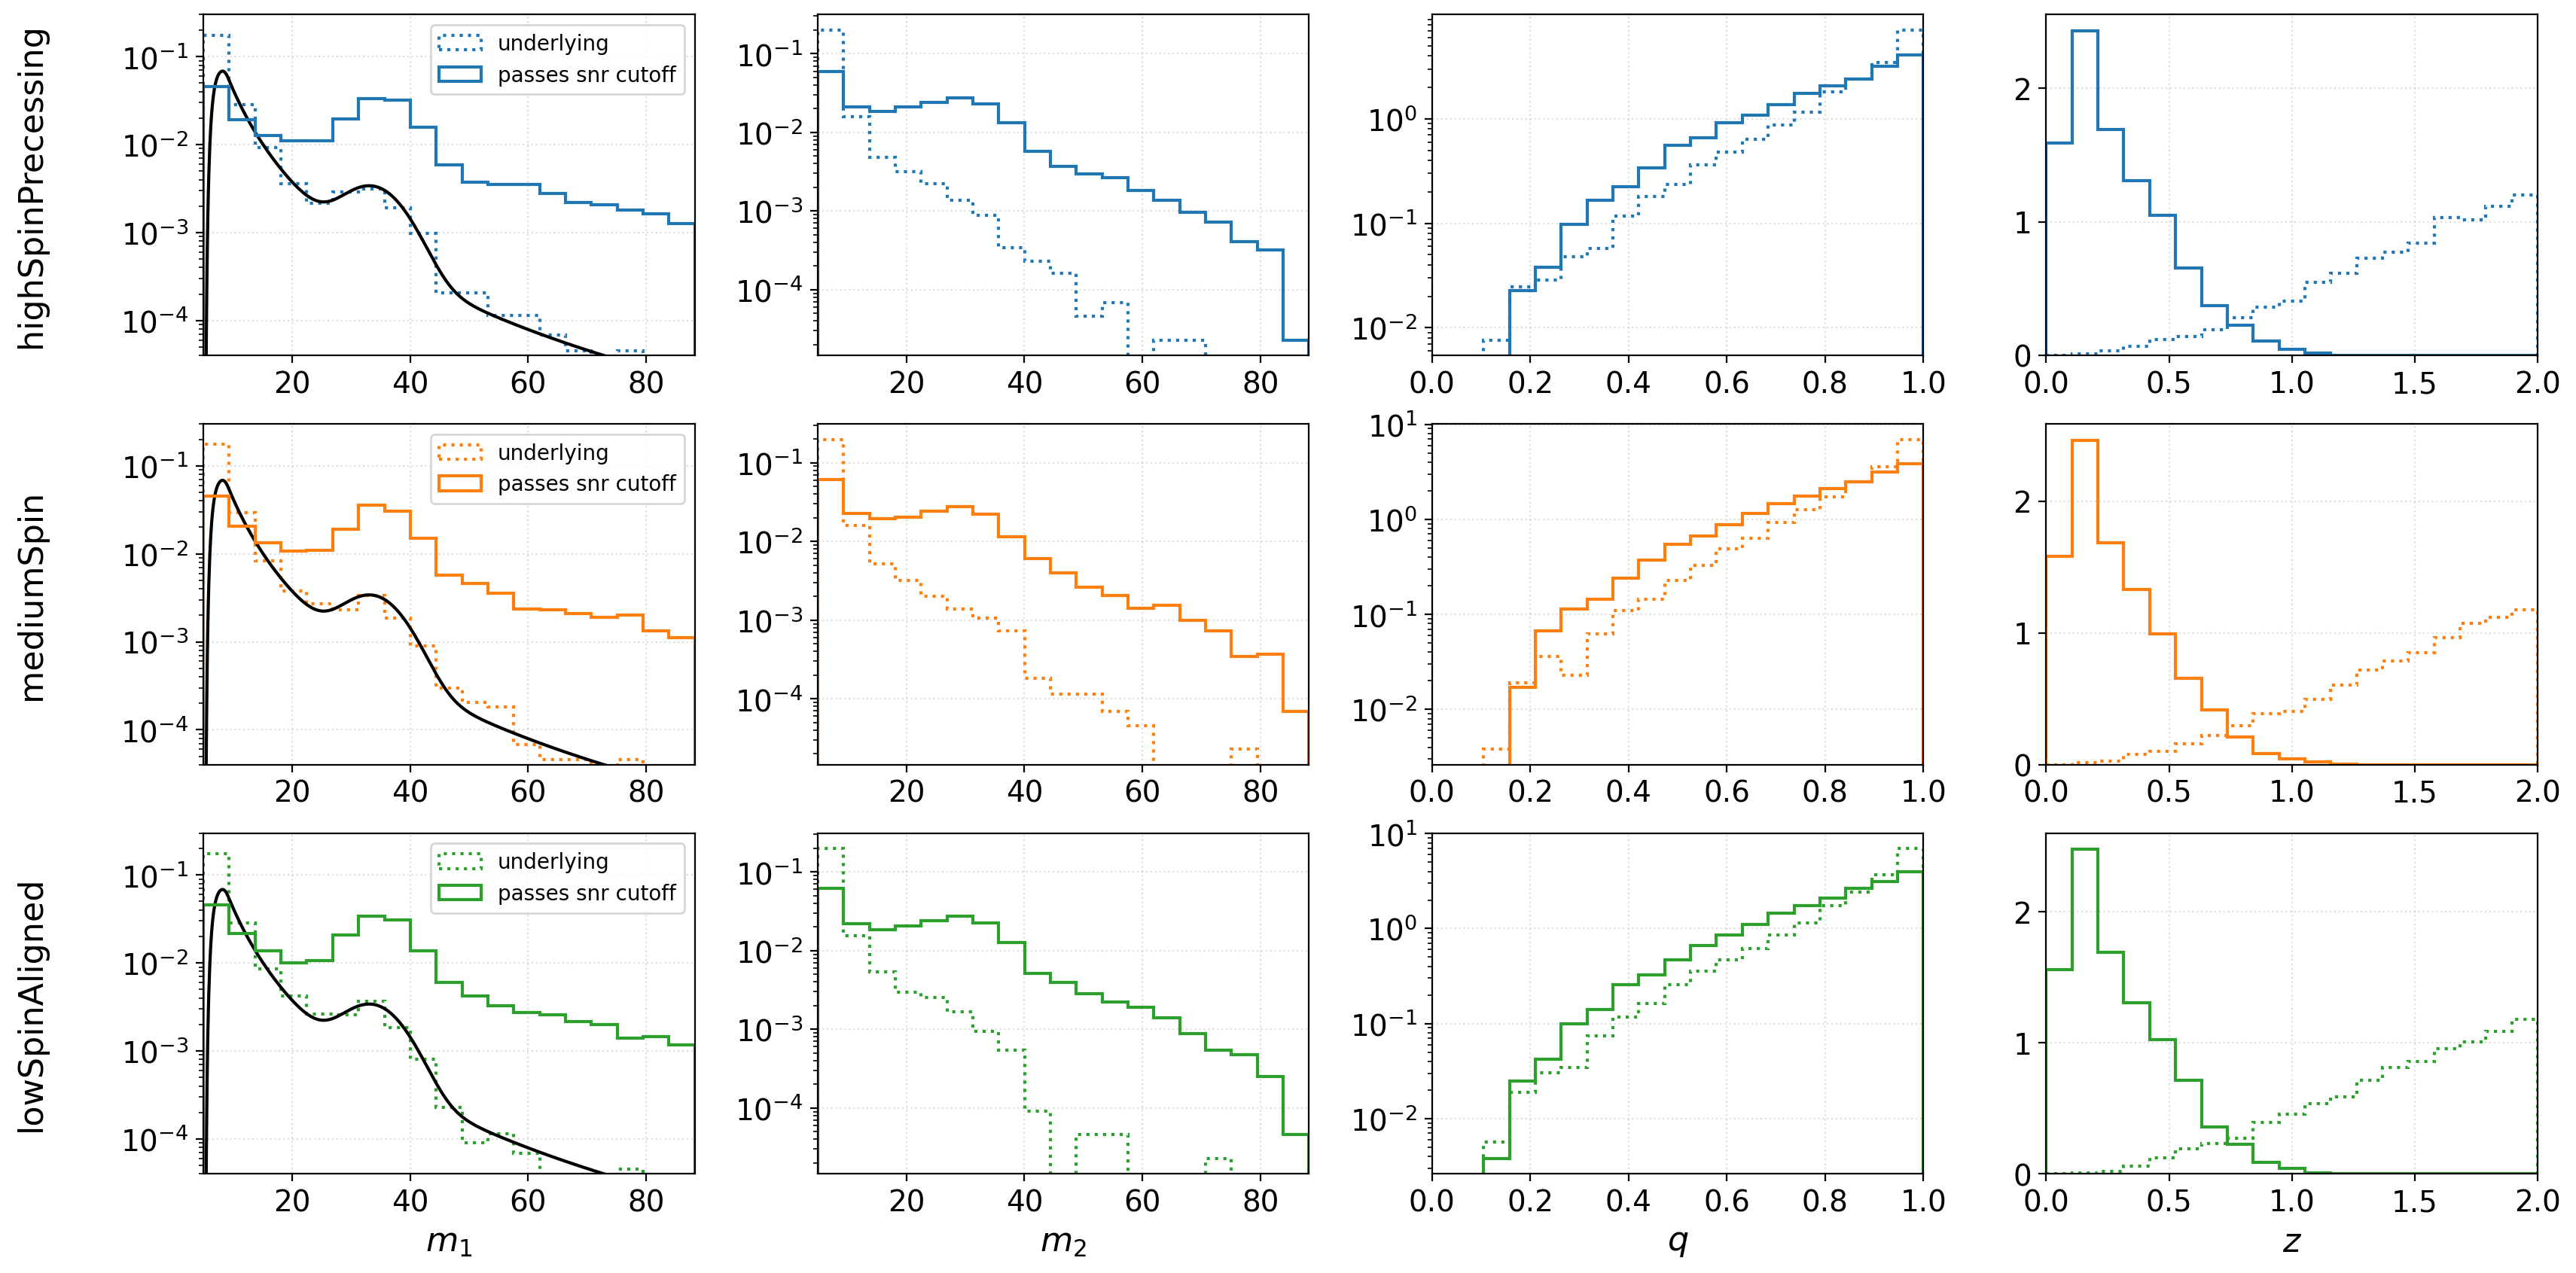

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,10))

for i,pop_underlying in enumerate([pop1_underlying, pop2_underlying, pop3_underlying]):
    # primary mass
    axes[i][0].hist(pop_underlying.m1, **inj_kwargs, color=f'C{i}', bins=massbins)
    axes[i][0].plot(massgrid, p_m1(massgrid), color='k')
    axes[i][0].set_yscale('log')
    axes[i][0].set_xlim(mMin,mMax)
    axes[i][0].set_ylim(4e-5, 3e-1)
    # secondary mass
    axes[i][1].hist(pop_underlying.m2, **inj_kwargs, color=f'C{i}', bins=massbins)
    axes[i][1].set_yscale('log')
    axes[i][1].set_xlim(mMin,mMax)
    # mass ratio 
    axes[i][2].hist(pop_underlying.m2/pop_underlying.m1, **inj_kwargs, color=f'C{i}', bins=np.linspace(0,1,20))
    axes[i][2].set_yscale('log')
    axes[i][2].set_xlim(0,1)
    # redshift
    axes[i][3].hist(pop_underlying.z, **inj_kwargs, color=f'C{i}', bins=np.linspace(0,2,20))
    axes[i][3].set_xlim(0,2)

for i,pop_detected in enumerate([pop1_detected,pop2_detected,pop3_detected]):
    # primary mass
    axes[i][0].hist(pop_detected.m1, **det_kwargs, color=f'C{i}', bins=massbins)
    # secondary mass
    axes[i][1].hist(pop_detected.m2, **det_kwargs, color=f'C{i}', bins=massbins)
    # mass ratio 
    axes[i][2].hist(pop_detected.m2/pop_detected.m1, **det_kwargs, color=f'C{i}', bins=np.linspace(0,1,20))
    # redshift
    axes[i][3].hist(pop_detected.z, **det_kwargs, color=f'C{i}', bins=np.linspace(0,2,20))
    
    axes[i][0].legend()    
    
axes[2][0].set_xlabel(r'$m_1$', fontsize=16)
axes[2][1].set_xlabel(r'$m_2$', fontsize=16)
axes[2][2].set_xlabel(r'$q$', fontsize=16)
axes[2][3].set_xlabel(r'$z$', fontsize=16)  

axes[0][0].set_ylabel('highSpinPrecessing', fontsize=16, rotation=90, labelpad=35)
axes[1][0].set_ylabel('mediumSpin', fontsize=16, rotation=90, labelpad=35)
axes[2][0].set_ylabel('lowSpinAligned', fontsize=16, rotation=90, labelpad=35)

for ax in axes: 
    for a in ax: 
        a.grid(color='silver', ls=':', alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()

## Look at extrinsic parameters

Should be the same for all three populations

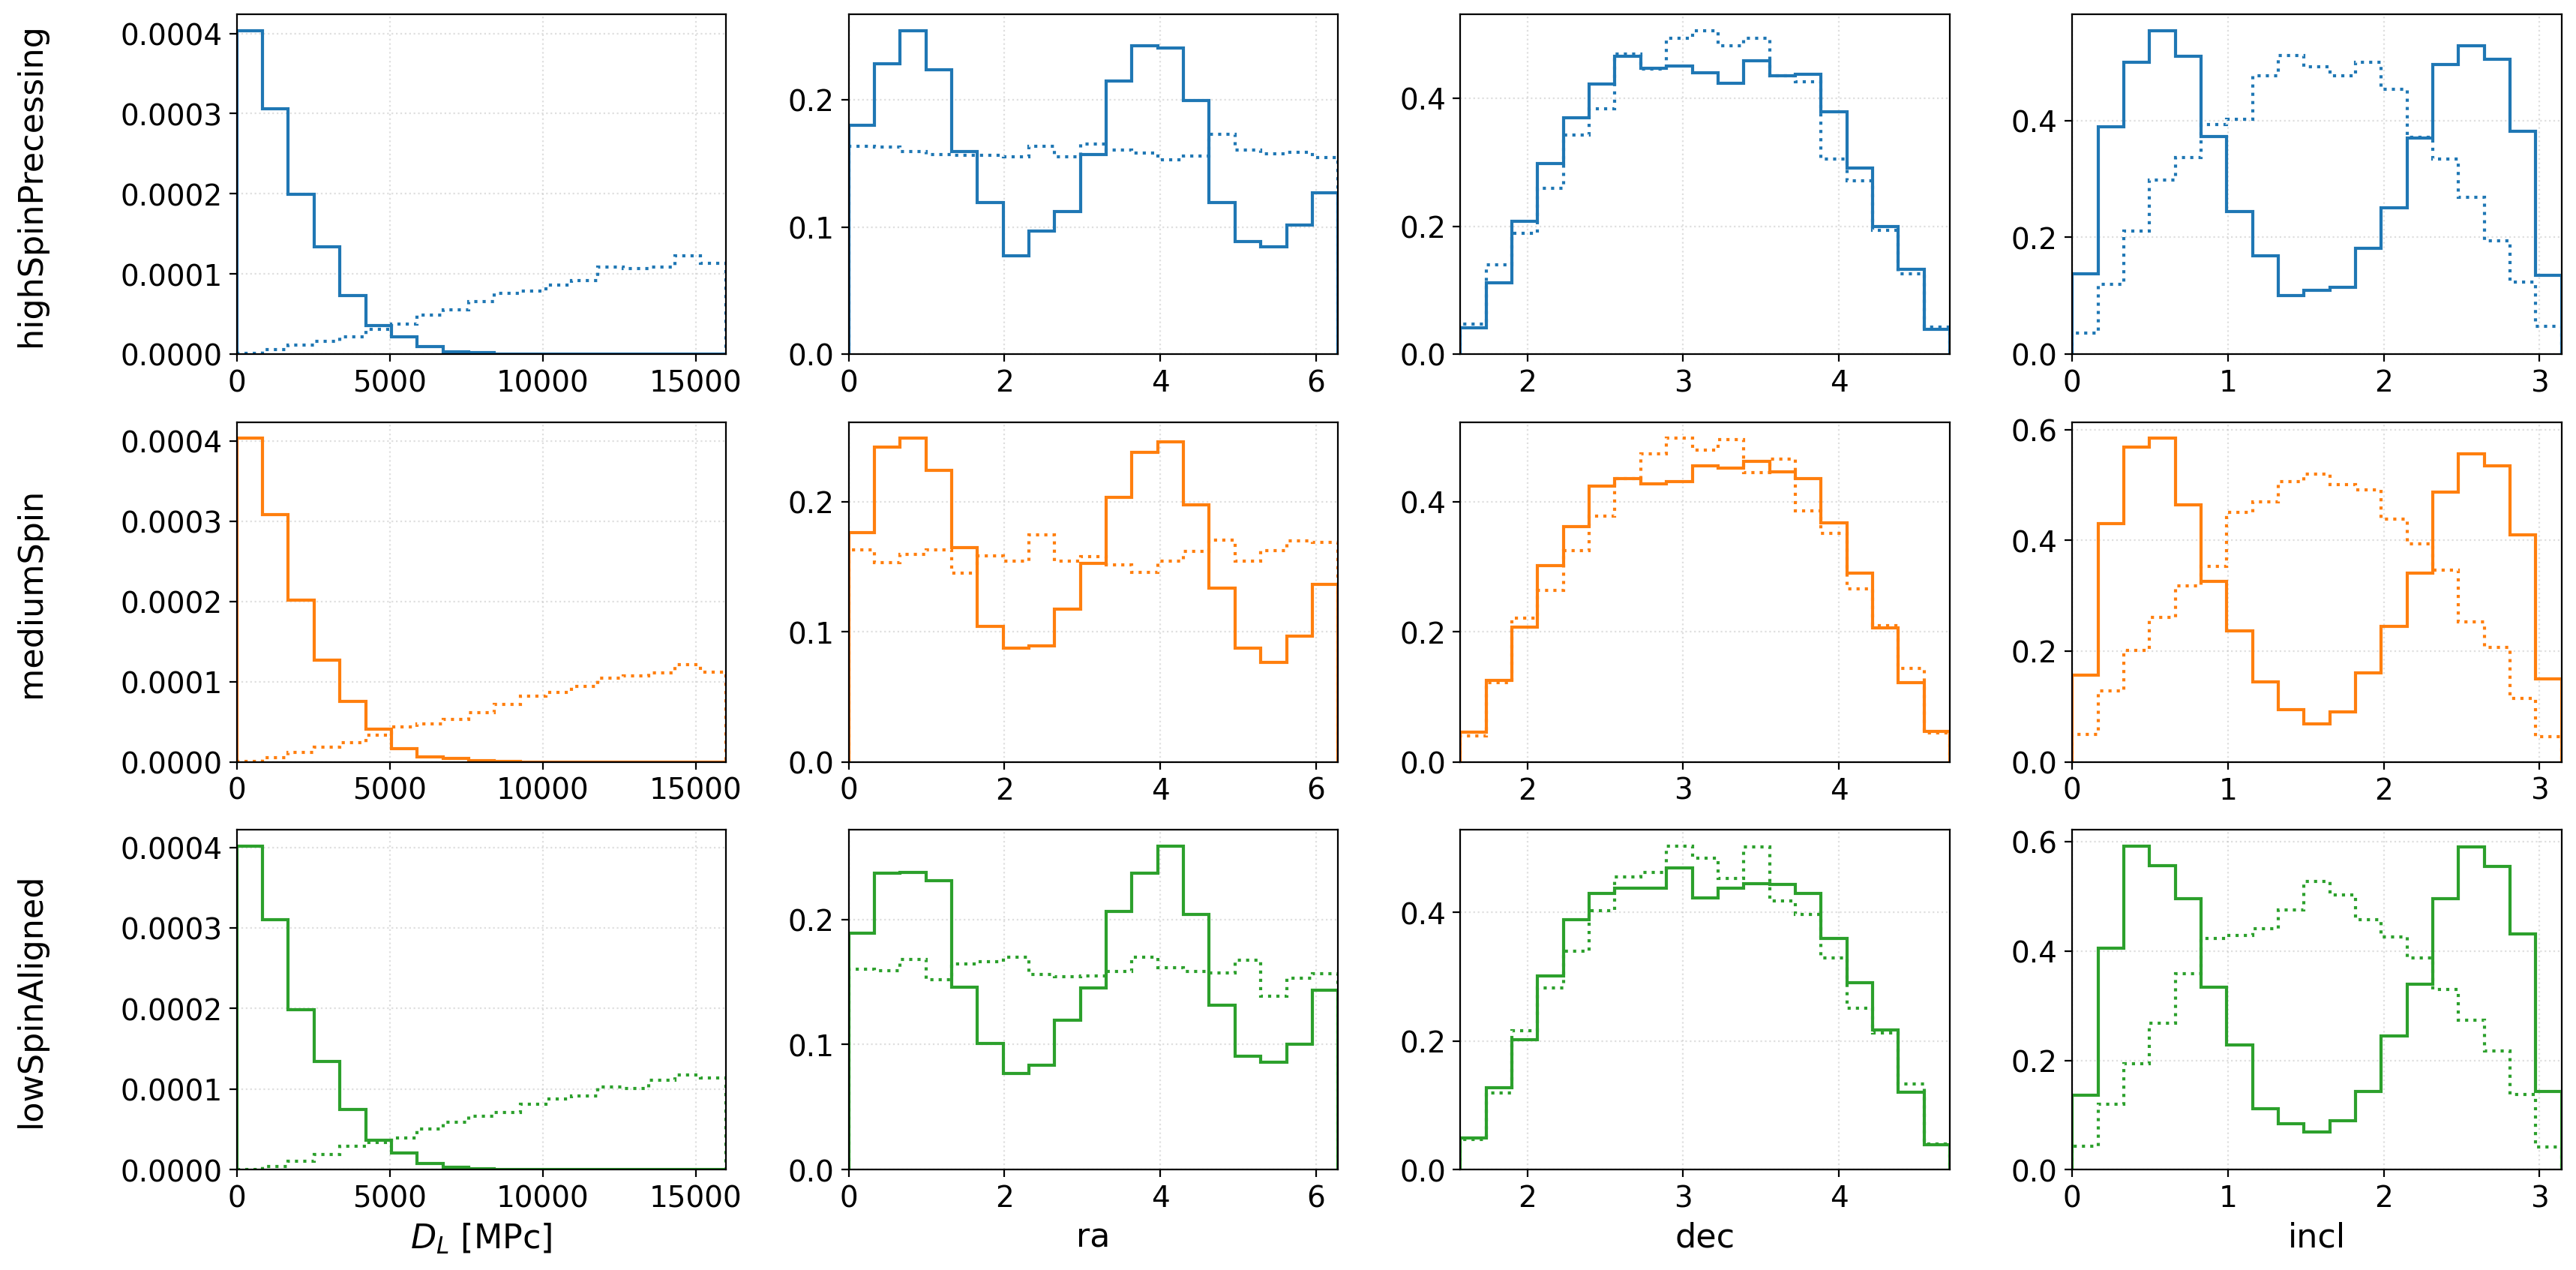

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,10))

for i,pop_underlying in enumerate([pop1_underlying, pop2_underlying, pop3_underlying]):
  
    # luminosity distance
    axes[i][0].hist(pop_underlying.Dl, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, 16000, 20))
    axes[i][0].set_xlim(0,16000)
    # right ascension
    axes[i][1].hist(pop_underlying.ra, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, 2*np.pi, 20))
    axes[i][1].set_xlim(0,2*np.pi)
    # declination
    axes[i][2].hist(pop_underlying.dec, **inj_kwargs, color=f'C{i}', bins=np.linspace(np.pi/2, 3/2*np.pi, 20))
    axes[i][2].set_xlim(np.pi/2, 3/2*np.pi)
    # inclination
    axes[i][3].hist(pop_underlying.inc, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, np.pi, 20))
    axes[i][3].set_xlim(0, np.pi)

for i,pop_detected in enumerate([pop1_detected,pop2_detected,pop3_detected]):

    # luminosity distance
    axes[i][0].hist(pop_detected.Dl, **det_kwargs, color=f'C{i}', bins=np.linspace(0, 16000, 20))
    # right ascension
    axes[i][1].hist(pop_detected.ra, **det_kwargs, color=f'C{i}', bins=np.linspace(0, 2*np.pi, 20))
    # declination)
    axes[i][2].hist(pop_detected.dec, **det_kwargs, color=f'C{i}', bins=np.linspace(np.pi/2, 3/2*np.pi, 20))
    # inclination
    axes[i][3].hist(pop_detected.inc, **det_kwargs, color=f'C{i}', bins=np.linspace(0, np.pi, 20))

axes[2][0].set_xlabel(r'$D_L$ [MPc]', fontsize=16)
axes[2][1].set_xlabel(r'ra', fontsize=16)
axes[2][2].set_xlabel(r'dec', fontsize=16)
axes[2][3].set_xlabel(r'incl', fontsize=16)  

axes[0][0].set_ylabel('highSpinPrecessing', fontsize=16, rotation=90, labelpad=35)
axes[1][0].set_ylabel('mediumSpin', fontsize=16, rotation=90, labelpad=35)
axes[2][0].set_ylabel('lowSpinAligned', fontsize=16, rotation=90, labelpad=35)

for ax in axes: 
    for a in ax: 
        a.grid(color='silver', ls=':', alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()

### For `injectionDict`

In [4]:
injectionDictPop = pd.read_json('flat_pop_full_mass_range_for_injection_dict.json')

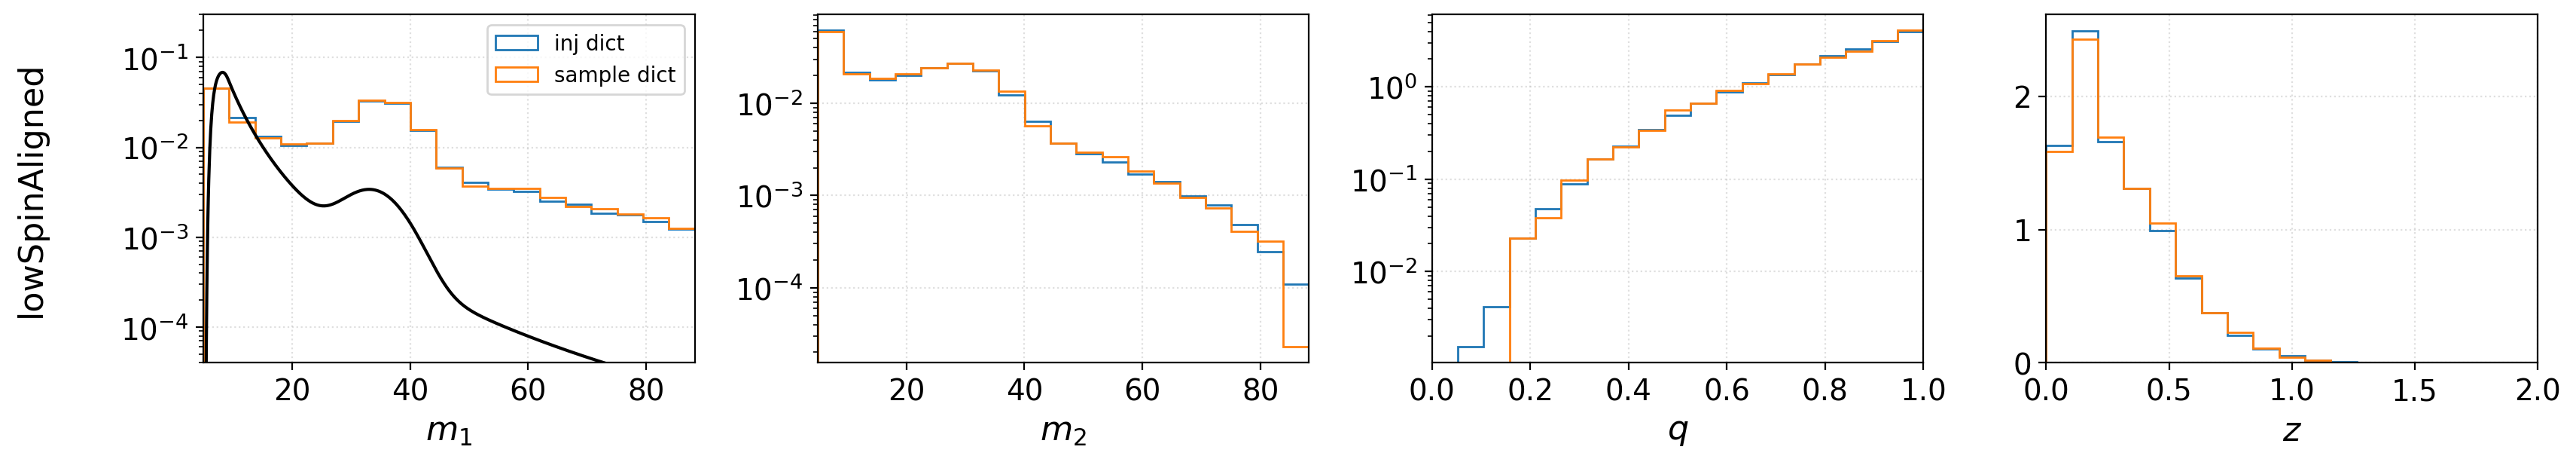

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,3))

# primary mass
axes[0].hist(injectionDictPop.m1, bins=massbins, density=True, histtype='step', label='inj dict')
axes[0].hist(pop1_detected.m1, bins=massbins, density=True, histtype='step', label='sample dict')
axes[0].plot(massgrid, p_m1(massgrid), color='k')
axes[0].set_yscale('log')
axes[0].set_xlim(mMin,mMax)
axes[0].set_ylim(4e-5, 3e-1)

# secondary mass
axes[1].hist(injectionDictPop.m2, bins=massbins, density=True, histtype='step')
axes[1].hist(pop1_detected.m2, bins=massbins, density=True, histtype='step')
axes[1].set_yscale('log')
axes[1].set_xlim(mMin,mMax)

# mass ratio 
axes[2].hist(injectionDictPop.m2/injectionDictPop.m1, bins=np.linspace(0,1,20), density=True, histtype='step')
axes[2].hist(pop1_detected.m2/pop1_detected.m1, bins=np.linspace(0,1,20), density=True, histtype='step')
axes[2].set_yscale('log')
axes[2].set_xlim(0,1)

# redshift
axes[3].hist(injectionDictPop.z, bins=np.linspace(0,2,20), density=True, histtype='step')
axes[3].hist(pop1_detected.z, bins=np.linspace(0,2,20), density=True, histtype='step')
axes[3].set_xlim(0,2)

axes[0].legend()    
    
axes[0].set_xlabel(r'$m_1$', fontsize=16)
axes[1].set_xlabel(r'$m_2$', fontsize=16)
axes[2].set_xlabel(r'$q$', fontsize=16)
axes[3].set_xlabel(r'$z$', fontsize=16)  

axes[0].set_ylabel('highSpinPrecessing', fontsize=16, rotation=90, labelpad=35)
axes[0].set_ylabel('mediumSpin', fontsize=16, rotation=90, labelpad=35)
axes[0].set_ylabel('lowSpinAligned', fontsize=16, rotation=90, labelpad=35)

for ax in axes: 
    ax.grid(color='silver', ls=':', alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()